In [1]:
import sys
sys.path.insert(0, '/home/jovyan/Proj/ml_combiner/TSEBRA/bin')
import os
import csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
import matplotlib.pyplot as plt
from genome_anno import Anno
from overlap_graph import Graph
from evidence import Evidence
from gnn import GNN
import pickle
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [2]:
def describe_features(graph):
    n_f = []
    e_f = []
    for node in graph.nodes.values():
        n_f.append(node.feature_vector)
    for edge in graph.edges.values():
        e_f.append(edge.feature_vector_n1_to_n2)
        e_f.append(edge.feature_vector_n2_to_n1)
    n_f = np.array(n_f)
    e_f = np.array(e_f)
    _, ax = plt.subplots(ncols = 1, nrows=4, figsize=(15,9))
    i = int(n_f.shape[1] / 4 + 0.5)
    for j in range(4):
        ax[j].boxplot([n_f[:,k] for k in range(i*j, min(i*(j+1), n_f.shape[1]))])
        ax[j].set_ylim([-3,3])
    #plt.savefig(out + 'node_features.png', dpi=200)
    
    _, ax = plt.subplots(ncols = 1, nrows=4, figsize=(15,9))
    i = int(e_f.shape[1] / 4 + 0.5)
    for j in range(4):
        ax[j].boxplot([e_f[:,k] for k in range(i*j, min(i*(j+1), e_f.shape[1]))])
        ax[j].set_ylim([-3,3])
    plt.show()
    #plt.savefig(out + 'edge_features.png', dpi=200)

In [3]:
quiet = True

numb_batches_train = 950
numb_batches_val = 200
batch_size = 128
v=0
parent_dir = '/home/jovyan/Proj/ml_combiner/data/dummy'
out = f'{parent_dir}/train/train5'
weight_class_one = 1.


In [4]:
c = 1
gene_sets = []
for b in ['braker1', 'braker2']:        
    gene_sets.append(Anno(f'{parent_dir}/{b}.gtf', f'anno{c}'))
    gene_sets[-1].addGtf()
    gene_sets[-1].norm_tx_format()
    c += 1

ref_anno = Anno(f'{parent_dir}/annot.gtf', 'reference')
ref_anno.addGtf()
ref_anno.norm_tx_format()

# read hintfiles
evi_train = Evidence()
for h in ['hints1', 'hints2']:    
    evi_train.add_hintfile(f'{parent_dir}/{h}.gff')    

In [5]:
graph = Graph(gene_sets, verbose=v)
graph.build()
graph.add_node_features(evi_train)
graph.add_edge_features(evi_train)
graph.add_reference_anno_label(ref_anno)

NODES
MEAN:   [0.44444444 0.32892371 0.14788308 0.35122529 0.52380952 0.49608889
 0.25398773 0.5184514  0.78222222 0.71666667 0.70555556 0.68333333
 0.24288182 0.38500164 0.45333333 0.38983051 0.         0.66666667
 0.66666667 0.6        0.         0.34197865 0.66666667 0.36111111
 0.         0.86666667 0.73333333 0.6        0.         0.41252542
 0.73333333 0.43174603 0.82222222 0.13333333 0.73333333 0.70555556
 0.75182814 0.72194795] 
STD:   [3.02254900e-01 3.85411927e-01 3.00871027e-01 4.04060789e-01
 2.59075629e-01 2.74076806e-01 2.78215028e-01 2.41909024e-01
 3.53158587e-01 4.01155738e-01 3.95421326e-01 3.96979335e-01
 3.54179921e-01 3.63541360e-01 3.53773311e-01 3.61431819e-01
 1.00000000e-17 4.71404521e-01 4.71404521e-01 4.89897949e-01
 1.00000000e-17 3.29906304e-01 4.71404521e-01 3.63135352e-01
 1.00000000e-17 3.39934634e-01 4.42216639e-01 4.89897949e-01
 1.00000000e-17 3.81045897e-01 4.42216639e-01 4.01985498e-01
 3.41384255e-01 3.39934634e-01 4.04420024e-01 3.95421326e-01
 4.

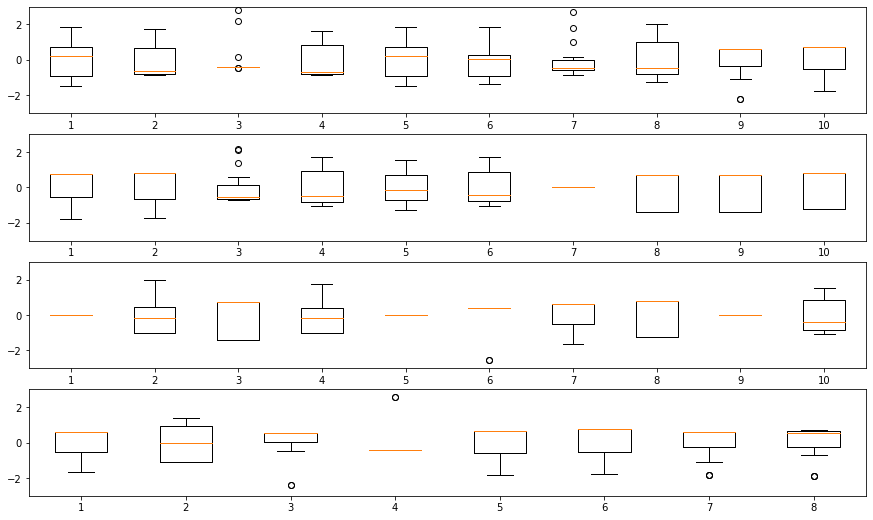

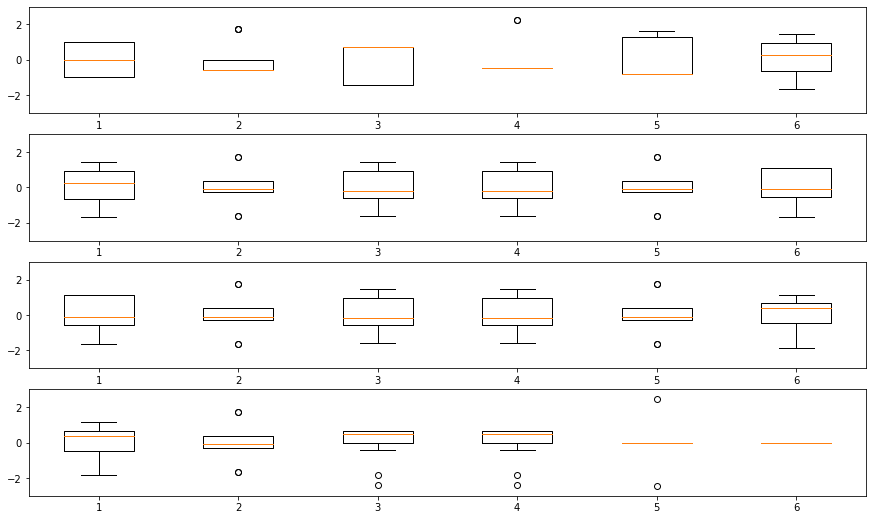

In [6]:
describe_features(graph)

In [7]:
def print_struc(tx):
    print(tx.id, tx.start, tx.end, tx.strand, tx.chr)
    c1 = tx.get_type_coords('CDS', False)
    c2 = tx.get_type_coords('intron', False)
    str = f'C {c1[0][0]}-{c1[0][1]}'
    for i in range(len(c2)):
        str += f' I {c2[i][0]}-{c2[i][1]}'
        str += f' C {c1[i+1][0]}-{c1[i+1][1]}'
    print(str, '\n')

In [8]:
print('TRANSCRIPT INTRON/EXON STRUCTURE\n')
for g in gene_sets:
    for t in g.transcripts.values():
        print_struc(t)
        

TRANSCRIPT INTRON/EXON STRUCTURE

g13394.t1 19769461 19770745 - 2R
C 19769461-19769517 I 19769518-19769578 C 19769579-19769731 I 19769732-19770105 C 19770106-19770321 I 19770322-19770385 C 19770386-19770745 

g7220.t1 15852697 15853966 + 2L
C 15852697-15852700 I 15852701-15852752 C 15852753-15853966 

g10571.t1 25243523 25244976 - 3R
C 25243523-25243992 I 25243993-25244053 C 25244054-25244424 I 25244425-25244488 C 25244489-25244976 

g6158.t1 6654897 6656233 - 2L
C 6654897-6655013 I 6655014-6655069 C 6655070-6656141 I 6656142-6656195 C 6656196-6656233 

g5956.t1 5062743 5070303 + 2L
C 5062743-5063210 I 5063211-5066869 C 5066870-5067249 I 5067250-5067308 C 5067309-5068227 I 5068228-5068295 C 5068296-5068394 I 5068395-5069126 C 5069127-5069219 I 5069220-5070096 C 5070097-5070303 

g5956.t2 5062743 5070303 + 2L
C 5062743-5063210 I 5063211-5066869 C 5066870-5067249 I 5067250-5067308 C 5067309-5068227 I 5068228-5068295 C 5068296-5068394 I 5068395-5070096 C 5070097-5070303 

g13417.t1 202366

In [9]:
components = graph.connected_components()
print('CONNECTED COMPONENTS\n')
for c in components:
    print(c, components[c])
    """for t in components[c]:
        t2 = graph.__tx_from_key__(t)
        print_struc(t2)
    print('\n')"""

CONNECTED COMPONENTS

g_1 ['anno1;g13394.t1', 'anno2;g11468.t1']
g_2 ['anno1;g13417.t1']
g_3 ['anno1;g7220.t1']
g_4 ['anno1;g6158.t1']
g_5 ['anno1;g5956.t1', 'anno1;g5956.t2', 'anno2;g646.t1']
g_6 ['anno1;g6386.t1', 'anno2;g1078.t1']
g_7 ['anno1;g10571.t1']
g_8 ['anno1;g3299.t1', 'anno2;g12871.t1']
g_9 ['anno1;g1394.t1']
g_10 ['anno1;g85.t1']


In [10]:
from termcolor import colored
print(colored('hello', 'red'), colored('world', 'green'))
evi_list = {'intron' : {'E' : [], 'P': [], 'C': [], 'M': []}, \
            'start_codon' : {'E' : [], 'P': [], 'C': [], 'M': []}, \
            'stop_codon': {'E' : [], 'P': [], 'C': [], 'M': []}}
tx = graph.__tx_from_key__('anno1;g85.t1')

coords = {}

for i, type in enumerate(["intron", "CDS"]):#, "3'-UTR", "5'-UTR"]):
    coords.update({type : tx.get_type_coords(type, frame=False)})    
                
for type in ['intron', 'start_codon', 'stop_codon']:
    for line in tx.transcript_lines[type]:
        hint = evi_train.get_hint(line[0], line[3], line[4], line[2], \
            line[6])
        if hint:
            for key in hint.keys():
                if key not in evi_list[type].keys():
                    evi_list[type].update({key : []})
                evi_list[type][key].append([line[3], line[4]])
print(evi_list['intron'])
bc = evi_train.get_best_chain(tx.chr, coords, 'CDSpart', tx.strand)
print(bc)

hello world
{'E': [[750228, 752271]], 'P': [[750228, 752271]], 'C': [[750228, 752271]], 'M': [[750228, 752271]]}
(1.0, 0.895)


In [11]:

with open('save_graph.pkl', 'wb') as outp:
    pickle.dump(graph, outp, pickle.HIGHEST_PROTOCOL)

In [12]:
with open('save_graph', 'rb') as inp:
    graph = pickle.load(inp)

FileNotFoundError: [Errno 2] No such file or directory: 'save_graph'